In [1]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import wfdb
from utils import qrs_detect, comp_cosEn, save_dict
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


pd.set_option("display.max_rows", None, "display.max_columns", None)
%matplotlib inline

## Data Preprocessing

In [2]:
def load_record(sample_path):
    
    '''  returns signal, global label, local labels ''' 
    
    sig, fields = wfdb.rdsamp(sample_path)
    ann_ref = wfdb.rdann(sample_path, 'atr')
    
    #print(wfdb.rdsamp(sample_path))
    #print("\n\n", wfdb.rdann(sample_path, 'atr').aux_note)
    
    label = fields['comments'][0]
    fs = fields['fs']
    sig = sig[:, 1]
    length = len(sig)
    
    #print("Signal: ", sig)
    #print("\nLabel: ", label)
    
    beat_loc = np.array(ann_ref.sample) # r-peak locations
    ann_note = np.array(ann_ref.aux_note) # rhythm change flag
    
    return sig, length, fs, label, ann_note, beat_loc


In [16]:
def normalize(signal):

    values = signal
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)
    normalized = [item for sublist in normalized for item in sublist]
    
    #print(normalized)

    return normalized

In [ ]:
def build_input():
    
    ''' Builds input DF '''

    DATA_PATH = "/Users/Hasan/Desktop/Workspace/cpsc2021-AFIB/afib_data"
    RESULT_PATH = "/Users/Hasan/Desktop/Workspace/cpsc2021-AFIB/afib_data/output"
    if not os.path.exists(RESULT_PATH):
        os.makedirs(RESULT_PATH)
        
    test_set = open(os.path.join(DATA_PATH, 'RECORDS'), 'r').read().splitlines()[0:10]
    
    input_df = pd.DataFrame(columns=["Signal", "Signal Length", "Label"])
  
    for i, sample in enumerate(test_set):
        
        #print("\n\n\n", sample)
        sample_path = os.path.join(DATA_PATH, sample)
        sig, sig_len, fs, label, label_arr, beat_loc  = load_record(sample_path)
        
        #sig = normalize_signal(sig)
        
        input_df.at[i, 'Signal'] = sig
        input_df.at[i, 'Signal Length'] = sig_len
        input_df.at[i, 'Label'] = label
    
        #input_df.append(build_seq_input(sample_path))
        #pred_dict = challenge_entry(sample_path)
        
    return input_df
    
df = build_input()
df.to_pickle("/Users/Hasan/Desktop/Workspace/cpsc2021-AFIB/afib_data/df.pkl")
df.info()

In [107]:
def build_chunked_input(start, stop):
    
    ''' Builds chunked DF input  '''

    DATA_PATH = "/Users/Hasan/Desktop/Workspace/cpsc2021-AFIB/afib_data"
    RESULT_PATH = "/Users/Hasan/Desktop/Workspace/cpsc2021-AFIB/afib_data/output"
    if not os.path.exists(RESULT_PATH):
        os.makedirs(RESULT_PATH)
        
    test_set = open(os.path.join(DATA_PATH, 'RECORDS'), 'r').read().splitlines()[start:stop]
    seconds = 1
    chunksize = seconds*200
    
    input_df = pd.DataFrame(columns=["Signal", "Granular Labels", "Sequence Label", "Chunk Label", "Signal Length"])
  
    #test_set=["Training_set_II/data_86_9"]
    
    for i, sample in enumerate(test_set):
        
        #print("\n\n\n", sample)
        #print(i, end='\r')
        sample_path = os.path.join(DATA_PATH, sample)
        sig, sig_len, fs, label, label_arr, beat_loc = load_record(sample_path)
        loc_labels = ['non atrial fibrillation']*sig_len
        r_peaks = beat_loc #qrs_detect(sig, fs)
        
        #print(sig)
        sig = normalize(sig)
        
        printlabelarr = False 
        af_ranges = []
        af_range = []
        
        ## Calculate exact AF ranges in sequence
        ''' Label arr acts as an index for which peaks in r_peaks are afib; '''
        
        #print('Label arr: ', label_arr)
        
        for li, l in enumerate(label_arr):
            if l == "(AFIB" or l == "(AFL":
                #print("AFIB detected")
                printlabelarr = True
                start = r_peaks[li]
                af_range.append(start)
                #print(np.where(label_arr == l)[0])
                #loc_labels[ r_peaks[ label_arr.index(mini_label) ]] = 'AFIB'
            if l == "(N":
                stop = r_peaks[li]
                af_range.append(stop)
                af_ranges.append(af_range)
                af_range = []
        
        #print("\n", af_ranges)
        ## Label AF for AF sections of the signal
        for rng in af_ranges:
            start = rng[0]
            stop = rng[1]
            #print("Signal AF start/stop ranges: ", start, stop)
            #print(r_peaks[start], r_peaks[stop])
            loc_labels[ start : stop ] = ['AFIB'] * (stop-start) 
        
       
        #print("Signal: ", sig)
        #print("Signal len: ", sig_len)
        #print("QRS Peak locations: ", r_peaks)
        #print(len(r_peaks))
        
        
        #if printlabelarr: 
            #print("Label Arr: ", label_arr)
            #print(len(label_arr))
            #print("AF ranges: ", af_ranges)
            #print("Granular Labels: ", loc_labels[0:10])
            #print(len(loc_labels))
        #print("Sequence Label: ", label)
       
        chunked_sig   = np.split(sig, chunksize)
        chunked_label = np.split(loc_labels, chunksize)
        
        #print(len(chunked_sig), len(chunked_label))

        input_df.at[i, 'Signal'] = chunked_sig
        input_df.at[i, 'Granular Labels'] = chunked_label
        input_df.at[i, 'Signal Length'] = sig_len
        input_df.at[i, 'Sequence Label'] = label

    
        #input_df.append(build_seq_input(sample_path))
        #pred_dict = challenge_entry(sample_path)
        
    input_df = input_df.explode(["Signal", "Granular Labels"])
    
    #print("\n", input_df["Granular Labels"])
    
    #input_df["Chunk Label"] = input_df["Granular Labels"].apply(lambda x: Counter(x).most_common(1)[0][0])
    #input_df["Chunk Label"] = input_df["Granular Labels"].apply(lambda x: Counter(x).most_common(1)[0][0])
    input_df["Chunk Label"] = input_df["Granular Labels"].str[0]
     
    input_df = input_df.drop(['Granular Labels'], axis=1)
    return input_df

dfs = []

for i in range(0,1):
    df = build_chunked_input(0+(200*i), 200+(200*i))
    print(df.shape)
    dfs.append(df)   
    
chunk_df = pd.concat(dfs)   
chunk_df.info(null_counts=True)

AttributeError: 'list' object has no attribute 'shape'

In [6]:
chunk_df = chunk_df.dropna()

In [106]:
chunk_df.head()

,Signal,Sequence Label,Chunk Label,Signal Length
0,"[0.42781279089285984, 0.43075796188063664, 0.4...",non atrial fibrillation,non atrial fibrillation,520088
0,"[0.34093787673009723, 0.34156353481558344, 0.3...",non atrial fibrillation,non atrial fibrillation,520088
0,"[0.3958737086264516, 0.3964230669454151, 0.397...",non atrial fibrillation,non atrial fibrillation,520088
0,"[0.37496757259922786, 0.3760815491904595, 0.37...",non atrial fibrillation,non atrial fibrillation,520088
0,"[0.5733469655582853, 0.6473424791320138, 0.703...",non atrial fibrillation,non atrial fibrillation,520088


In [105]:
chunk_df['Signal'].iloc[200].size

3056

In [25]:
chunk_df.to_pickle("/Users/Hasan/Desktop/Workspace/cpsc2021-AFIB/afib_data/chunk_df.pkl")

In [ ]:
chunk_df['Chunk Label'].value_counts()

In [ ]:
DATA_PATH = "/Users/Hasan/Desktop/Workspace/cpsc2021-AFIB/afib_data"
sample_path = os.path.join(DATA_PATH, "Training_set_I/data_25_20")
sig, sig_len, fs, label, label_arr, beat_loc = load_record(sample_path)
pd.Series(label_arr).value_counts()

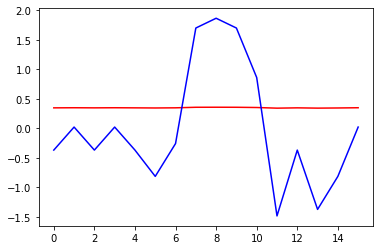

In [5]:
test_sig = df.iloc[0, 0][0:300]
test_sig_mean = np.mean(test_sig)
test_sig_std = np.std(test_sig)
norm_sig = (test_sig - test_sig_mean) / test_sig_std
plt.plot(test_sig, color='r')
plt.plot(norm_sig, color='b')

In [ ]:
print(max(test_sig), min(test_sig))
print(max(norm_sig), min(norm_sig))

In [ ]:
test_sig

## Model

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding, MaxPooling1D
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics

In [26]:
chunk_df.Signal.head()

0    [0.42781279089285984, 0.43075796188063664, 0.4...
0    [0.42386046298698327, 0.421098411438861, 0.417...
0    [0.36205765210358454, 0.37277013932337366, 0.3...
0    [0.5523034899513207, 0.564480932688346, 0.5972...
0    [0.38361996612290367, 0.3867177366437259, 0.38...
Name: Signal, dtype: object

In [28]:
chunk_df = chunk_df.sample(frac=1)
X = chunk_df['Signal']
y = chunk_df['Chunk Label']

In [75]:
X.head()

194    [0.4869455083698289, 0.4884561976408832, 0.488...
32     [0.4412805957394861, 0.44350851492400667, 0.44...
65     [0.6841695660135506, 0.6808429469572117, 0.691...
52     [0.35661966672770556, 0.3576268082768724, 0.35...
177    [0.24636044559743628, 0.24637570578361057, 0.2...
Name: Signal, dtype: object

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [86]:
X_train[3].shape

(12033,)

In [71]:
np.size(X_train)

2412000

In [67]:
#X_train.shape[0]
X_train = np.expand_dims(X_train, axis=0)
shape = np.size(X_train)
shape

2412000

In [42]:
batch = 16
epochs = 10
shape = np.size(X_train, 1)


model = Sequential()
model.add(Dense(100, activation='relu', input_shape = (shape,1)))
model.add(Conv1D(100, 10, activation='relu'))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) 
model.summary()
model.compile(loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy'])

X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)


model.fit(X_train,Y_train, batch_size = batch, epochs = epochs)
score = model.evaluate(X_test, Y_test, batch_size = batch)
score

2021-12-09 18:26:12.783760: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2412000, 100)      200       
                                                                 
 conv1d (Conv1D)             (None, 2411991, 100)      100100    
                                                                 
 conv1d_1 (Conv1D)           (None, 2411982, 100)      100100    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 803994, 100)      0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 803985, 160)       160160    
                                                                 
 conv1d_3 (Conv1D)           (None, 803976, 160)       256160    
                                                        

AxisError: axis 2 is out of bounds for array of dimension 2